In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = 'D:\zzStudies\CSE499\ASL\Datasets\Dataset 1 - Image - Keggle'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/asl_alphabet_train/asl_alphabet_train")

['asl_alphabet_test', 'asl_alphabet_train']


In [3]:
transform = tt.Compose(
    [
        tt.RandomRotation(degrees=15),
        tt.Resize(64), #was 32
        tt.Grayscale(num_output_channels=1),
        tt.ToTensor(),
        tt.Normalize([0.5], [0.5])
    ]
)
dataset = ImageFolder(data_dir+"/asl_alphabet_train/asl_alphabet_train", transform)

In [4]:
print(dataset.classes)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [5]:
random_seed = 42
torch.manual_seed(random_seed);
print(len(dataset))

87000


In [6]:
val_size = 17400
train_size = len(dataset) - val_size

train_ds, val_ds= random_split(dataset, [train_size, val_size])

print(len(train_ds), len(val_ds))

69600 17400


In [7]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow((img.permute(1, 2, 0)))

Label:  A (0)


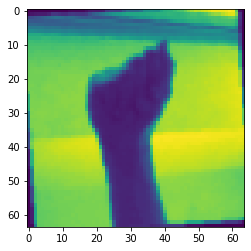

In [8]:
show_example(*dataset[0])

In [9]:
def get_default_device():
    # Pick GPU if available, else CPU 
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    # Move tensor(s) to chosen device 
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    # Wrap a dataloader to move data to a device 
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
     #   Yield a batch of data after moving it to device
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
     #   Number of batches
        return len(self.dl)

In [10]:
device = get_default_device()
device

device(type='cuda')

In [11]:
batch_size= 1024

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=4, pin_memory=True)

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


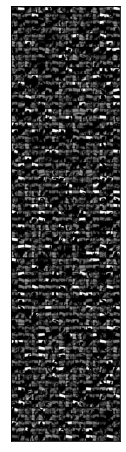

In [13]:
show_batch(train_dl)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [15]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
class ASLModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
                                # input: 256 x 1 x 64 x 64   
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),                                         
            nn.MaxPool2d(2, 2), # output: 32 x 32 x 32 
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25),  # output: 128 x 16 x 16
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 256 x 8 x 8
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 384 x 4 x 4
            
            nn.Conv2d(384, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # output: 512 x 2 x 2
            nn.Dropout(0.50),
            
            nn.Flatten(),
            nn.Linear(512*2*2, 39)) 
            
    def forward(self, xb):
        return self.network(xb)

In [18]:
model = ASLModel()
to_device(model, device);
model

ASLModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_s

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        loop = tqdm(train_loader)
        # Training Phase 
        model.train()
        train_losses = []
        for batch in loop:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
model = to_device(ASLModel(), device)

In [21]:
history = [evaluate(model, val_dl)]
history

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.48s/it]


[{'val_loss': 3.663578510284424, 'val_acc': 0.03448000177741051}]

In [22]:
num_epochs = 30
opt_func = torch.optim.SGD
lr = 0.001

In [23]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.5997, val_loss: 3.2598, val_acc: 0.1144


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.3068, val_loss: 3.0700, val_acc: 0.1739


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.1344, val_loss: 2.9326, val_acc: 0.2073


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.9811, val_loss: 2.8104, val_acc: 0.2432


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.8389, val_loss: 2.6794, val_acc: 0.2837


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.7011, val_loss: 2.5595, val_acc: 0.3179


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.5716, val_loss: 2.4389, val_acc: 0.3564


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.4480, val_loss: 2.3212, val_acc: 0.3942


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.3252, val_loss: 2.2120, val_acc: 0.4316


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [9], train_loss: 2.2165, val_loss: 2.1206, val_acc: 0.4574


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [10], train_loss: 2.1213, val_loss: 2.0238, val_acc: 0.4827


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [11], train_loss: 2.0347, val_loss: 1.9399, val_acc: 0.5082


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.9518, val_loss: 1.8568, val_acc: 0.5328


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.8705, val_loss: 1.7937, val_acc: 0.5422


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.7985, val_loss: 1.7212, val_acc: 0.5666


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.7379, val_loss: 1.6755, val_acc: 0.5765


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.6771, val_loss: 1.6136, val_acc: 0.5906


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.6180, val_loss: 1.5608, val_acc: 0.6068


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [18], train_loss: 1.5671, val_loss: 1.5109, val_acc: 0.6186


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [19], train_loss: 1.5205, val_loss: 1.4611, val_acc: 0.6290


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [20], train_loss: 1.4738, val_loss: 1.4144, val_acc: 0.6445


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [21], train_loss: 1.4293, val_loss: 1.3651, val_acc: 0.6571


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [22], train_loss: 1.3921, val_loss: 1.3270, val_acc: 0.6664


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [23], train_loss: 1.3505, val_loss: 1.2987, val_acc: 0.6786


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [24], train_loss: 1.3151, val_loss: 1.2583, val_acc: 0.6881


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [25], train_loss: 1.2739, val_loss: 1.2310, val_acc: 0.6909


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [26], train_loss: 1.2475, val_loss: 1.1840, val_acc: 0.7116


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [27], train_loss: 1.2122, val_loss: 1.1487, val_acc: 0.7183


  0%|                                                                                           | 0/68 [00:00<?, ?it/s]

Epoch [28], train_loss: 1.1825, val_loss: 1.1238, val_acc: 0.7240


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.46s/it]

Epoch [29], train_loss: 1.1545, val_loss: 1.1093, val_acc: 0.7219


In [24]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [25]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

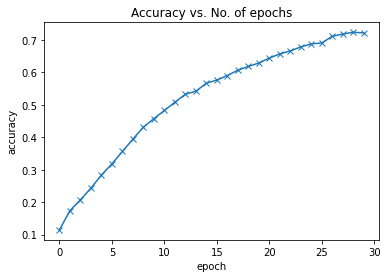

In [26]:
plot_accuracies(history)

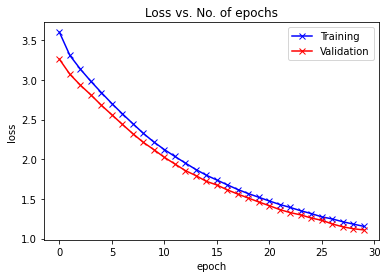

In [27]:
plot_losses(history)

In [28]:
history = [evaluate(model, val_dl)]
history

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:13<00:00,  1.47s/it]


[{'val_loss': 1.1069363355636597, 'val_acc': 0.7244287133216858}]

In [29]:
torch.save(model.state_dict(), 'CNN0.pth')

In [30]:
#torch.save(model.state_dict(), 'CNN0.h5')

In [31]:
def predict_single(input, target, model):
    predictions = model(input)
    _, preds = torch.max(predictions, dim=1)
    
    print("Target:", target)
    print("Prediction:", preds)
    print("Predicted Label:", dataset.classes[preds[0]])


Label:  U (tensor(20))
Target: tensor(20, device='cuda:0')
Prediction: tensor([22], device='cuda:0')
Predicted Label: W


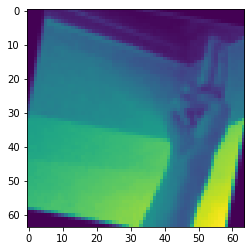

In [32]:
for input, label in val_dl:
    show_example(input[10].cpu(), label[10].cpu())
    predict_single(input[10].view(1, 1, 64, 64), label[10], model) # Was predict_single(input[0].view(1, 3, 32, 32)
    break